In [1]:
#загрузка библиотек 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# библиотека для отрисовки метрик классификации
from yellowbrick.classifier import ROCAUC

## Загрузка и подготовка данных

In [2]:
# загружаем датасет
df = pd.read_csv("input.csv", sep=';')[['what_emotion_does_the_author_express_specifically_about_the_weather', 'tweet_text']]
# переименовываем столбец
df = df.rename(index=str, columns={'what_emotion_does_the_author_express_specifically_about_the_weather': 'class'})
# выкидываем строки с пропусками
df = df.dropna()

In [3]:
# переименовываем метки классов с помощью словаря
classes_dict = {
                  'Positive' : 1,
                  'Neutral / author is just sharing information' : 0,
                  'Negative' : -1
               }

df['class'] = df['class'].apply(lambda x: classes_dict[x] if x in classes_dict.keys() else 'garbage')
# выкидываем все, что не попало в эти три класса
df = df[df['class'] != 'garbage']
df.head()

,class,tweet_text
0,1,Grilling kabobs on the grill last night was am...
1,-1,The slowest day ever !! And the weather makes ...
2,0,Fire Weather Watch issued May 17 at 4:21PM CDT...
3,1,Im going to lunch early today. The weather i...
4,0,Weekend Weather Causes Delays In I-270 Bridge ...


In [4]:
from sklearn.model_selection import train_test_split

# создаем лист текстов
texts = df['tweet_text'].values
# классы (в том же порядке для текстов)
target = df['class'].values.astype('int32') 
# разбивка 
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.1)

## Baseline: TF-IDF и RidgeClassifier без пунктуации.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

# преобразуем документы в вектора с помощью TfidfVectorizer
def tf_idf_vectorize_train_test(X_train, X_test):
    vectorizer = TfidfVectorizer()
#   создаем словарь слов texts_train
    vectorizer.fit(X_train)
    return vectorizer.transform(X_train), vectorizer.transform(X_test)

X_train, X_test = tf_idf_vectorize_train_test(texts_train, texts_test)

# создаем классификатор и обучаем
model = RidgeClassifier()
model.fit(X_train, y_train)
# f1 устойчива к мощностям классов
print('f1_score: {}'.format(f1_score(y_test, model.predict(X_test), average='micro')))

f1_score: 0.7402597402597403


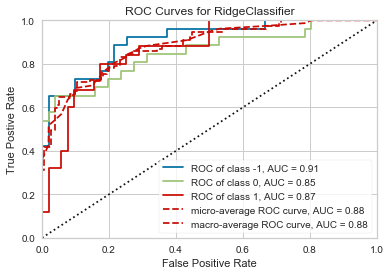

In [6]:
# строим ROC-кривые и считаем AUC
visualizer = ROCAUC(RidgeClassifier(), classes=[-1, 0, 1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

## TF-IDF и RidgeClassifier без пунктуации и со стеммингом.

In [7]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

# заменяем слова на основу слова
def preprocessor(twit):
    stemmer = SnowballStemmer('english')
    tokenizer=RegexpTokenizer(r'[a-zA-Z]+\-?[a-zA-Z]+')  
    return ' '.join([stemmer.stem(word) for word in tokenizer.tokenize(twit)])

In [8]:
# используем TfidfVectorizer с препроцессором
def tf_idf_vectorize_train_test(X_train, X_test, max_features=None):
    vectorizer = TfidfVectorizer(token_pattern=r'[a-zA-Z]+\-?[a-zA-Z]+', preprocessor=preprocessor)
    vectorizer.fit(X_train)
    return vectorizer.transform(X_train), vectorizer.transform(X_test)

X_train, X_test = tf_idf_vectorize_train_test(texts_train, texts_test)

model = RidgeClassifier()
model.fit(X_train, y_train)
print('f1_score: {}'.format(f1_score(y_test, model.predict(X_test), average='micro')))

f1_score: 0.7272727272727273


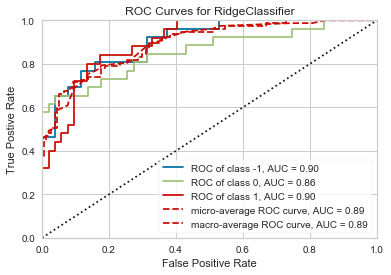

In [9]:
visualizer = ROCAUC(RidgeClassifier(), classes=[-1, 0, 1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

### Видим, что результат по метрике f1-score ухудшился. ROC-AUC значительно не улучшился. Видимо, стемминг, в данном случае, делать не нужно.

## Загружаем предобученный word2vec.

In [10]:
import gensim.downloader as api

word2vec_model = api.load("glove-wiki-gigaword-100")

### Модель загружена. Посмотрим на векторное представление слова "погода".

In [11]:
word2vec_model.wv['weather']

array([-1.0770e+00, -4.2305e-01,  7.2816e-01,  3.1298e-02, -8.5608e-01,
       -1.0674e+00,  3.0636e-01,  2.9915e-01, -1.1422e+00, -2.4928e-01,
        8.9267e-02, -7.3746e-01,  9.4393e-01, -7.7069e-01,  8.1351e-01,
       -4.3571e-01,  8.6461e-04, -7.8748e-01,  2.3369e-01,  2.6158e-01,
       -5.2750e-01,  3.8901e-01,  9.5790e-01,  1.7041e-01, -4.2107e-01,
        2.6841e-01, -5.9422e-01, -2.7610e-02, -4.3908e-01, -6.1150e-02,
       -5.0471e-01, -1.2419e-01, -4.6748e-01,  3.6254e-01, -4.4388e-01,
        6.0595e-01, -1.8125e-01, -4.0161e-01,  5.4966e-01, -7.3956e-02,
       -1.0279e+00, -9.9115e-02, -6.5336e-01,  1.9828e-04,  4.5476e-01,
       -2.1899e-01,  2.0762e-01, -3.1110e-01,  5.7836e-01, -1.1213e+00,
        6.1019e-01,  8.4058e-02,  1.6671e-01,  6.4629e-01,  9.2916e-01,
       -2.1362e+00,  7.8269e-01,  9.0944e-01,  1.7399e+00,  6.6094e-01,
       -4.6687e-01,  9.6174e-01, -6.9801e-01, -3.3346e-01,  3.0522e-01,
        1.0064e-01, -6.2036e-01, -1.1825e+00,  5.1180e-01, -4.17

## Или обучаем word2vec на нашем датасете. 
### Из-за небольшого размера датасета результат получился неудовлетворительным: около 45%.

In [ ]:
# from nltk.stem import SnowballStemmer
# from nltk.tokenize import RegexpTokenizer

# def preprocessor(twit):
#     stemmer = SnowballStemmer('english')
#     tokenizer=RegexpTokenizer(r'[a-zA-Z]+\-?[a-zA-Z]+')  
#     return [stemmer.stem(word) for word in tokenizer.tokenize(twit)]

In [ ]:
# from gensim.test.utils import common_texts, get_tmpfile
# from gensim.models import Word2Vec

# path = get_tmpfile("word2vec.model")

# preprocessed_texts = [preprocessor(text) for text in texts]
# word2vec_model = Word2Vec(preprocessed_texts, size=100, window=5, min_count=1, workers=4)
# word2vec_model.save("word2vec.model")

In [ ]:
# word2vec_model = Word2Vec.load("word2vec.model")
# word2vec_model.train(preprocessed_texts, total_examples=1, epochs=1)

In [ ]:
# word2vec_model.wv['weather']

### Создаем список всех слов встречающихся в texts_train.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z]+\-?[a-zA-Z]+')
X_train = vectorizer.fit(texts)
vocab = vectorizer.vocabulary_.keys()

### Создаем словарь слова-векторные_представления.

In [23]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

vocab = [lemmatizer.lemmatize(word) for word in vocab]
dict_words_vecs = {word : word2vec_model[word] for word in vocab if word in word2vec_model.wv.vocab.keys() }

In [24]:
len(dict_words_vecs.keys())

2095

## Кластеризуем векторные представления.

In [25]:
from nltk.cluster import KMeansClusterer
import nltk

X = np.array(list(dict_words_vecs.values()))
# n_clasters = round(len(X) / 20)
n_clasters = 100
kclusterer = KMeansClusterer(n_clasters, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print('Проведено разбинение на {} кластеров'.format(n_clasters))

Проведено разбинение на 100 кластеров


### Создаем словарь слова-номера_кластеров.

In [26]:
dict_words_clasters = {list(dict_words_vecs.keys())[i] : assigned_clusters[i] for i in range(len(dict_words_vecs.keys()))}

In [27]:
len(dict_words_clasters.keys())

2095

### Формируем векторные представления твитов на основе кластеризации и обучаем на них модель.
### Ищем лучшие значения гиперпараметров для модели RandomForest с помощью перебора по сетке.
### Слова, для которых не оказалось предобученных векторов, а значит, и кластеров, используем сами по себе. В том числе используем символы ")" и "(", которые, предположительно, имеют большое значение при анализе тональности.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# в функции препроцессор заменяем те слова, которые были в предобученной модули word2vec на номера их кластеров,
# остальные - на основу слова
def preprocessor(twit):
    stemmer = SnowballStemmer('english')
    tokenizer=RegexpTokenizer(r'[a-zA-Z]+\-?[a-zA-Z]+|[\(\)]+')
    return ' '.join([str(dict_words_clasters[word]) if word in dict_words_clasters.keys() else stemmer.stem(word) 
                     for word in tokenizer.tokenize(twit)])

def vectorize_train_test(X_train, X_test, max_features=None):
    vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z]+\-?[a-zA-Z]+|\d+|[\(\)]+', preprocessor=preprocessor)
    vectorizer.fit(X_test)
    return vectorizer.transform(X_train), vectorizer.transform(X_test)

X_train, X_test = vectorize_train_test(texts_train, texts_test)

# перебираем гиперпараметры по сетке для нахождения лучших значений
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True) 

param_grid = { 
                'n_estimators': [n*10 for n in range(5,50)],
                'max_features': ['auto', 'sqrt', 'log2']
             }
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
CV_rfc.best_params_

{'max_features': 'log2', 'n_estimators': 400}

In [40]:
# обучаем модель с лучшими гиперпараметрами
model = RandomForestClassifier(
                                   n_estimators = CV_rfc.best_params_['n_estimators'], 
                                   max_features = CV_rfc.best_params_['max_features'],
                                   random_state=2
                              )
model.fit(X_train, y_train)
print('f1_score: {}'.format(f1_score(y_test, model.predict(X_test), average='micro')))

f1_score: 0.6753246753246753


## Строим ROC-кривые.

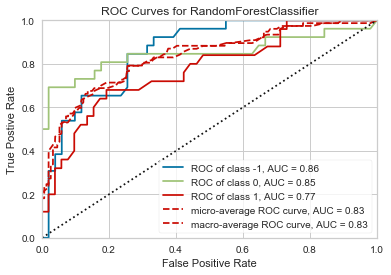

In [31]:
visualizer = ROCAUC(RandomForestClassifier(n_estimators = CV_rfc.best_params_['n_estimators'], 
                                           max_features = CV_rfc.best_params_['max_features'],
                                           random_state = 2), 
                    classes=[-1, 0, 1])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()